In [23]:
import sys
sys.path.append('/content/drive/MyDrive/Glaucoma_Detection/GUI')

In [24]:
import torch
from models import UNetFamily
import torch.backends.cudnn as cudnn
import os
# import argparse
# from config import parse_args
from extract_patches import *
import numpy as np
from dataset import TestDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from pre_process_1 import my_PreProc
from pre_process_2 import clahe_rgb
# from tkinter import *
# from tkinter import filedialog
# import tkinter as tk
from PIL import Image, ImageTk, ImageOps
# from fractal_dimension import fractal_dimension
# import tkinter.font as font
import cv2
from tqdm import tqdm
from imutils import contours
from skimage import measure
import imutils

# Optic Disc Detection

In [25]:
def point_check(pt):
  newpt = [0,0]
  newpt[0] = 0 if pt[0] < 0 else pt[0]
  newpt[1] = 0 if pt[1] < 0 else pt[1]
  return tuple(newpt)

def patch_extraction(img_path):
  output_dim = 512
  # img_path = "/content/drive/MyDrive/GUI/Predictions/IDRiD_12/IDRiD_12.jpg"
  image = Image.open(img_path)
  im_w, im_h = image.size
  var = round(0.15 * im_w)
  starting_threshold = 250

  while True:
    # load the image, convert it to grayscale, and blur it
    image = cv2.imread(img_path)
    # image[:, 2144:, :] = 0
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray,9,75,75)
    median=cv2.medianBlur(gray,5)
    # cv2_imshow(median)

    # threshold the image to reveal light regions in the blurred image
    thresh = cv2.threshold(median, starting_threshold, 255, cv2.THRESH_BINARY)[1]

    # perform a series of erosions and dilations to remove any small blobs of noise from the thresholded image
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    # perform a connected component analysis on the thresholded image, then initialize a mask to store only the "large" components
    labels = measure.label(thresh, neighbors=8, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")
    # print(np.unique(labels))

    largest_blob = 0
    # loop over the unique components
    for label in np.unique(labels):
      # if this is the background label, ignore it
      if label == 0:
        continue
      # print("Creating mask")
      # otherwise, construct the label mask and count the number of pixels
      labelMask = np.zeros(thresh.shape, dtype="uint8")
      labelMask[labels == label] = 255
      numPixels = cv2.countNonZero(labelMask)
      # if the number of pixels in the component is sufficiently large, then add it to our mask of "large blobs"
      if numPixels > largest_blob:
        largest_blob = numPixels
        mask = labelMask

    # find the contours in the mask, then sort them from left to right
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    #If there is nothing found for the image
    if cnts == []:
      starting_threshold -= 10
      # print("Decreasing threshold by 10. Now:", starting_threshold)
      continue

    cnts = contours.sort_contours(cnts)[0]

    for (i, c) in enumerate(cnts):
      (x, y, w, h) = cv2.boundingRect(c)

      center = (round(x+(w/2)), round(y+(h/2)))
      cv2.putText(image, "O", center, cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
      box_radius = output_dim//2

      # Dristi Dataset
      # tl_pt = [center[0]-box_radius-50, center[1]-box_radius-100]
      # br_pt = [center[0]+box_radius, center[1]+box_radius]

      # IDRiD Dataset
      tl_pt = [center[0]-box_radius-250, center[1]-box_radius-300]
      br_pt = [center[0]+box_radius+250, center[1]+box_radius+300]

      #Check if TL point is out of bounds
      if tl_pt[0] < 0:
        neg = tl_pt[0] * -1
        tl_pt[0] = 0
        br_pt[0] += neg

      if tl_pt[1] < 0:
        neg = tl_pt[1] * -1
        tl_pt[1] = 0
        br_pt[1] += neg

      #Check if BR point is out of bounds
      if br_pt[0] > im_w:
        pos = im_w-br_pt[0]
        br_pt[0] = im_w
        tl_pt[0] -= pos

      if br_pt[1] > im_h:
        pos = im_h-br_pt[1]
        br_pt[1] = im_h
        tl_pt[1] -= pos

      cv2.rectangle(image,tuple(tl_pt) , tuple(br_pt), (255,0,0), 3)
      break
    # print("Wid: ", br_pt[0]-tl_pt[0], "\tHei:", br_pt[1]-tl_pt[1])
    # image=cv2.resize(image,(512,512))
    image=cv2.resize(image,(im_w, im_h))
    # cv2_imshow(image)
    return tl_pt, br_pt
    break

In [26]:
class Test():
	def __init__(self, test_img):
		self.test_img = test_img
		self.stride_height = 64
		self.stride_width = 64
		self.test_patch_height = 128
		self.test_patch_width = 128
		assert (self.stride_height <= self.test_patch_height and self.stride_width <= self.test_patch_width)

		#Extract Patches
		self.patches_imgs_test, self.test_imgs, self.new_height, self.new_width = get_data_test_overlap(
			test_img=test_img,
			patch_height=self.test_patch_height,
			patch_width=self.test_patch_width,
			stride_height=self.stride_height,
			stride_width=self.stride_width
			)
		self.img_height =self.test_imgs.shape[2]
		self.img_width =self.test_imgs.shape[3]

		test_set = TestDataset(self.patches_imgs_test)
		self.test_loader = DataLoader(test_set, batch_size=48, shuffle=False, num_workers=4)

	def inference(self, net):
		net.eval()
		preds_outputs = []
		preds_prob_dist = []
		with torch.no_grad():
			for batch_idx, inputs in tqdm(enumerate(self.test_loader), total=len(self.test_loader)):
				inputs = inputs.cuda() #if you are using GPU
				outputs = net(inputs)
				outputs_prob_dist = outputs[:,1].data.cpu().numpy() #probability distribution
				outputs_mask = outputs.argmax(dim = 1).data.cpu().numpy() #segmentation mask
				preds_prob_dist.append(outputs_prob_dist)
				preds_outputs.append(outputs_mask)
		predictions_mask = np.concatenate(preds_outputs, axis=0)
		predictions_prob_dist = np.concatenate(preds_prob_dist, axis=0)
		self.pred_patches_mask = np.expand_dims(predictions_mask,axis=1)
		self.pred_patches_prob = np.expand_dims(predictions_prob_dist,axis=1)

		return self.pred_patches_mask, self.pred_patches_prob

	def evaluate(self):
		self.pred_imgs_mask = recompone_overlap(
			self.pred_patches_mask, self.new_height, self.new_width, self.stride_height, self.stride_width)

		self.pred_imgs_mask = self.pred_imgs_mask[:, :, 0:self.img_height, 0:self.img_width]

		self.pred_imgs_prob_dist = recompone_overlap(
			self.pred_patches_prob, self.new_height, self.new_width, self.stride_height, self.stride_width)

		self.pred_imgs_prob_dist = self.pred_imgs_prob_dist[:, :, 0:self.img_height, 0:self.img_width]

		return self.pred_imgs_mask, self.pred_imgs_prob_dist

def predict(test_img_path):
	#device
	device = torch.device("cuda" if torch.cuda.is_available() and True else "cpu")
	#Model Architecture
	net = UNetFamily.U_Net(1, 2).to(device)
	cudnn.benchmark = True
	# Load checkpoint
	# print('==> Loading checkpoint...')
	best_model_path = "/content/drive/MyDrive/Glaucoma_Detection/Experiments/Optic_Disc_Seg/best_model.pth"
	checkpoint = torch.load(best_model_path)
	net.load_state_dict(checkpoint['net'])

	eval = Test(test_img_path)
	pred_patches_mask, pred_patches_prob_dist = eval.inference(net)
	pred_img_mask, pred_img_prob_dist = eval.evaluate()

	return pred_img_mask, pred_img_prob_dist

In [27]:
if __name__ == '__main__':
  test_img_path = "/content/drive/MyDrive/Glaucoma_Detection/Dataset/IDRiD/Training/Images/IDRiD_04.jpg"
  test_img = np.asarray(Image.open(test_img_path))

  tl_pt, br_pt = patch_extraction(test_img_path)
  test_img_patch = test_img[tl_pt[1]:br_pt[1], tl_pt[0]:br_pt[0], :]

  patch = np.expand_dims(test_img_patch,0)
  patch = np.transpose(patch,(0,3,1,2))
  pred_img_mask, pred_img_prob_dist = predict(patch)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


In [28]:
from PIL import Image

test_img_path = "/content/drive/MyDrive/Glaucoma_Detection/Dataset/IDRiD/Training/Images/IDRiD_04.jpg"
test_mask_path = "/content/drive/MyDrive/Glaucoma_Detection/Dataset/IDRiD/Training/Optic_Disk_GTs/IDRiD_04_OD.tif"
test_img = np.asarray(Image.open(test_img_path))
test_mask = np.asarray(Image.open(test_mask_path))
test_mask = np.where(test_mask > 0, 1, 0)
test_img.shape, test_mask.shape, pred_img_mask.shape

((2848, 4288, 3), (2848, 4288), (1, 1, 1112, 1012))

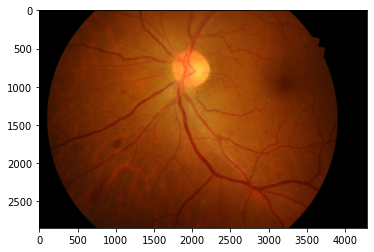

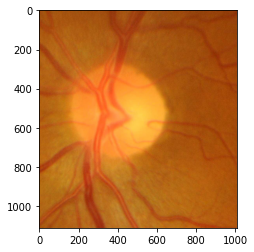

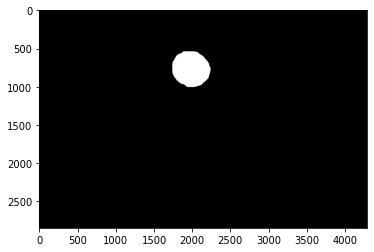

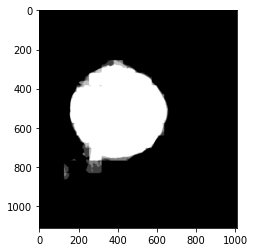

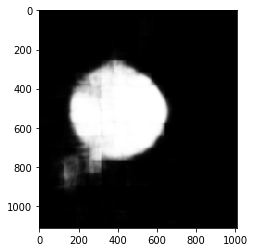

In [29]:
import matplotlib.pyplot as plt

plt.imshow(test_img)
plt.show()
plt.imshow(test_img_patch)
plt.show()
plt.imshow(test_mask, cmap="gray")
plt.show()
plt.imshow(pred_img_mask[0,0,:,:], cmap="gray")
plt.show()
plt.imshow(pred_img_prob_dist[0,0,:,:], cmap="gray")
plt.show()

In [ ]:
im = np.where(pred_img_mask > 0, 1, 0)
im = (255. * im[0,0,:,:]).astype(np.uint8)
im = Image.fromarray(im)
im.save('/content/drive/MyDrive/Glaucoma_Detection/Predictions/pred_patch_56.jpg')

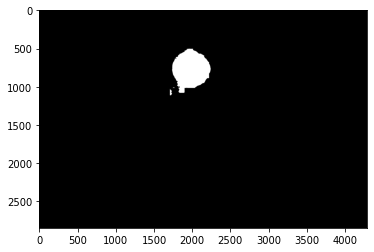

In [ ]:
im = np.where(pred_img_mask > 0, 1, 0)
prediction_mask = np.zeros((test_mask.shape))
prediction_mask[tl_pt[1]:br_pt[1], tl_pt[0]:br_pt[0]] = im

plt.imshow(prediction_mask, cmap="gray")

In [ ]:
final_prediction = prediction_mask

# Postprocessing

In [ ]:
import numpy as np
from skimage.measure import label   

def getLargestCC(segmentation):
    labels = label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat, weights=segmentation.flat))
    largestCC = np.where(largestCC == True, 1, 0)
    return largestCC

LCC = getLargestCC(final_prediction)
LCC.shape

(2848, 4288)

In [ ]:
np.unique(LCC)

array([0, 1])

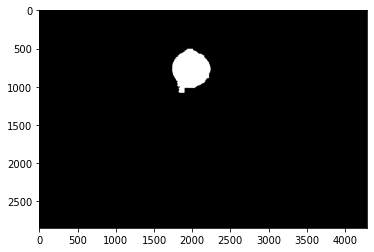

In [ ]:
plt.imshow(LCC, cmap="gray")

In [ ]:
im = (255. * LCC).astype(np.uint8)
im = Image.fromarray(im)
im.save('/content/drive/MyDrive/Glaucoma_Detection/Predictions/pred_patch_postprocess_56.jpg')

# DICE

In [ ]:
# DICE before postprocessing
dice = np.sum(2.0 * final_prediction * test_mask) / (np.sum(final_prediction) + np.sum(test_mask))
print(dice)

# DICE after postprocessing
dice = np.sum(2.0 * LCC * test_mask) / (np.sum(LCC) + np.sum(test_mask))
print(dice)

0.9399527876643443
0.9441668738631457


# Rough

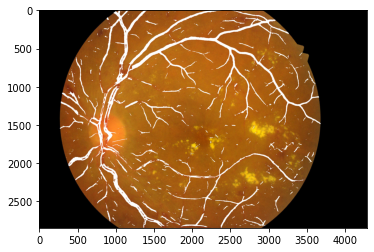

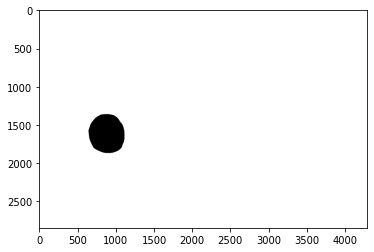

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

OD = np.asarray(Image.open("/content/drive/MyDrive/Glaucoma_Detection/Dataset/IDRiD/Testing/Optic_Disk_GTs/IDRiD_79_OD.tif"))
OD = np.where(OD == 0, 1, 0)
img = np.asarray(Image.open("/content/drive/MyDrive/Glaucoma_Detection/Predictions/IDRiD_79_combined.jpg"))

plt.imshow(img)
plt.show()
plt.imshow(OD, cmap="gray")
plt.show()

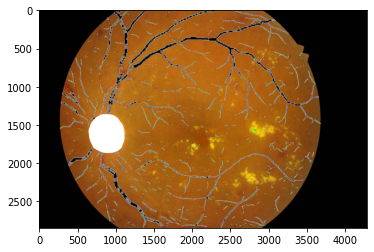

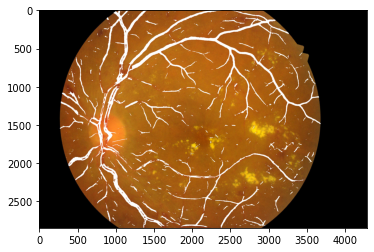

In [3]:
q = np.zeros((2848, 4288, 3)).astype('uint8')
q[:,:,0] = np.where(OD==0, 0, img[:,:,0])
q[:,:,1] = np.where(OD==0, 0, img[:,:,1])
q[:,:,2] = np.where(OD==0, 0, img[:,:,2])

OD_1 = np.where(OD==0, 255, OD)
OD_2 = np.where(OD==0, 255, OD)
OD_3 = np.where(OD==0, 255, OD)

q[:,:,0] = q[:,:,0] + OD_1
q[:,:,1] = q[:,:,1] + OD_2
q[:,:,2] = q[:,:,2] + OD_3

plt.imshow(q)
plt.show()
plt.imshow(img)
plt.show()

In [34]:
im = Image.fromarray(q)

In [37]:
im.save("/content/drive/MyDrive/Glaucoma_Detection/Predictions/IDRiD_04_combined_OD.jpg")